In [88]:
#! pip install spotipy numpy pandas seaborn beautifulsoup4 matplotlib python-dotenv wordcloud

In [89]:
import spotipy
import os
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
from collections import Counter
from wordcloud import WordCloud


In [90]:
load_dotenv()

True

In [91]:
# auth and token
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id = os.getenv('SPOTIFY_CLIENT_ID'),
    client_secret = os.getenv('SPOTIFY_CLIENT_SECRET'),
    redirect_uri='http://localhost:3000/callback',
    scope='user-top-read, playlist-read-private',
    #cache_path=cache_path
))

 long_term (calculated from ~1 year of data and including all new data as it becomes available), medium_term (approximately last 6 months), short_term (approximately last 4 weeks). Default: medium_term

## _clean dates fucntion_

In [ ]:
# clean dates
# normalise release dates to year - API returns varied mm/dd/yy or yyyy
# len() - str return int
# apply
def date_clean(date):
    if isinstance(date, str) and len(date) == 4 and date.isdigit():
        return int(date)
    elif isinstance(date, str):
        return pd.to_datetime(date, errors='coerce').year
    return date


# _get wiki function_

In [93]:


# uses beautifulsoup to get genres from wikipedia to fill out missing genres from Spotify API

def get_genres(artist_name):
    artist_name = artist_name.replace(" ", "_")

    url = f'https://en.wikipedia.org/wiki/{artist_name}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    table = soup.find("table", class_="infobox")
    if not table:
        return None
    
    # get 'Genres' without slice or indices - not always at same index in wiki infobox

    for row in table.find_all('tr'):
        heading = row.find('th')

        if heading and 'Genres' in heading.text:
            data = row.find('td')
            genres = [li.text.strip() for li in data.find_all('li')]

            # regex to remove the numbers from wiki eg. 'avant soul[2]'
            genres = [re.sub(r"\[\d+\]", "", genre) for genre in genres]

            if not genres:
                genres = data.text.strip().split(', ')

            return genres
    return None

pprint.pprint(get_genres('Frank Ocean'))

['Alternative R&B', 'psychedelic soul', 'avant-soul']


## _My Top Artists_

In [94]:
# get top artists from api

def get_artists(time_range='long_term', limit=20):
    results = sp.current_user_top_artists(time_range=time_range, limit=limit)
    artists = []

    for item in results['items']:
        genres = item.get('genres')
        artists.append({
            'name': item['name'],
            'genres': ', '.join(item['genres']),
            'popularity': item['popularity'],
            'followers': item['followers']['total'],
        })
    df = pd.DataFrame(artists)

    # add other for empty genre lists
    # later - adding genres from get_genres() function.
    df['Genres'] = df['genres'].apply(lambda x: x if x else 'other')

    return df



### _adding wiki scrape genres - func_

In [95]:
# create function to apply genress from get_genres()

# artists with other will receive genres from wikipedia get_genres() else 'other'

def add_genres(df):
    for index, row in df[df['Genres'] == 'other'].iterrows():
        artist_name = row['name']

        new_genres = get_genres(artist_name)

        # got the list??
        if new_genres:
            df.at[index, 'Genres'] = ', '.join(new_genres)
        else:
            print(f'None found for {artist_name}')
    return new_genres

In [96]:
# get all time frames from api 

my_artists_df = get_artists('short_term')
my_artists_med = get_artists('medium_term')
my_artists_long = get_artists('long_term')

In [97]:
add_genres(my_artists_df)


None found for Adolphe Adam
None found for BICEP


In [98]:
add_genres(my_artists_long)


None found for Agar Agar
None found for Acid Arab


In [99]:
add_genres(my_artists_med)

None found for Adolphe Adam
None found for Agar Agar


In [100]:
# concat all time frames into one df

all_top_artists = pd.concat([my_artists_df, my_artists_med, my_artists_long]).reset_index(drop=True).drop('genres', axis=1)

In [101]:
# final all top artists

all_top_artists

,name,popularity,followers,Genres
0,Skunk Anansie,52,388467,"Alternative rock, hard rock, grunge, alternati..."
1,Solange,61,2126538,"alternative r&b, neo soul"
2,Azealia Banks,63,1118923,hip house
3,Mariah Carey,79,11134563,christmas
4,Frank Ocean,87,17860343,"Alternative R&B, psychedelic soul, avant-soul"
5,Nine Inch Nails,67,2823975,"industrial rock, industrial, industrial metal,..."
6,The Internet,59,1480196,"alternative r&b, neo soul"
7,Adolphe Adam,45,8488,other
8,"Tyler, The Creator",90,20326092,"Alternative hip-hop, neo soul, West Coast hip ..."
9,Arctic Monkeys,86,29042575,"indie, garage rock"


### _plt bar chart for all my top artists_

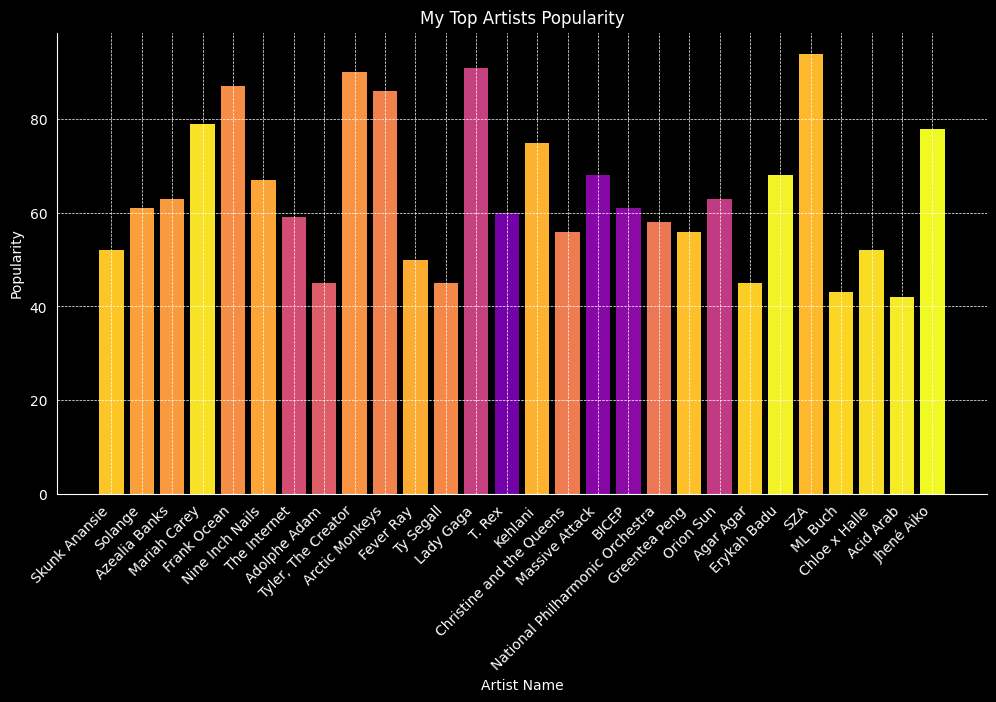

In [102]:
plt.figure(figsize=(12, 6), facecolor='black')

# plasma colormap
colors = plt.cm.plasma(np.linspace(0, 1, len(all_top_artists)))

plt.bar(all_top_artists['name'], all_top_artists['popularity'], color=colors)

ax = plt.gca()  

ax.set_facecolor("black")
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.title('My Top Artists Popularity', color='white')
plt.xlabel('Artist Name', color='white')  
plt.ylabel('Popularity', color='white')  

plt.xticks(rotation=45, ha='right', fontsize=10, color='white')  
plt.yticks(color='white')  

plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.show()

## _my top genres in top artists_

In [103]:
# access artist genres sublist from all_top_artists df to get top genres - zip

my_genres = [genre for sublist in all_top_artists['Genres'].str.split(', ') for genre in sublist]
genre_count = Counter(my_genres)
labels, sizes = zip(*genre_count.most_common(10))


/var/folders/ng/hh6jgtmd1r72zy8g7j7gjytc0000gp/T/ipykernel_3304/2796030874.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette=colors)
/var/folders/ng/hh6jgtmd1r72zy8g7j7gjytc0000gp/T/ipykernel_3304/2796030874.py:7: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette=colors)
/var/folders/ng/hh6jgtmd1r72zy8g7j7gjytc0000gp/T/ipykernel_3304/2796030874.py:7: UserWarning: The palette list has more values (60) than needed (46), which may not be intended.
  sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette=colors)


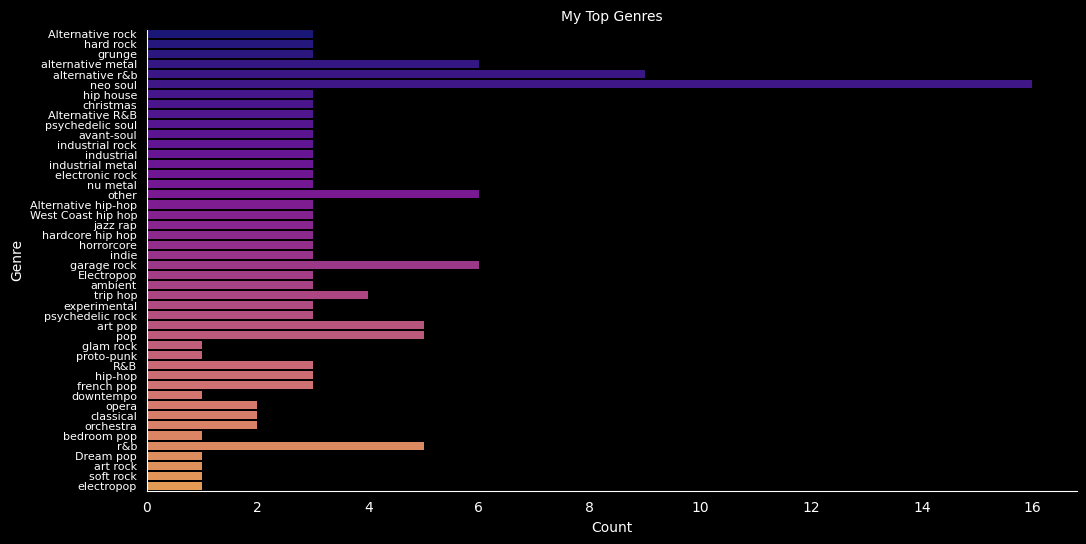

In [104]:
# plt top genres

plt.figure(figsize=(12,6), facecolor='black')
# plasma colormap
colors = plt.cm.plasma(np.linspace(0, 1, len(all_top_artists)))

sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette=colors)

ax = plt.gca()  
ax.set_facecolor("black")
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.xlabel("Count", color='white')
plt.ylabel("Genre", color='white')
plt.title('My Top Genres', fontsize=10, color='white')

plt.yticks(fontsize=8, color='white')  
plt.xticks(color='white')  

plt.show()


### _searching for creative data visuals - word cloud_

found word cloud in [this repo ([In 35:])](https://github.com/areevesman/spotify-wrapped/blob/main/code/01_Data_Visualization.ipynb)

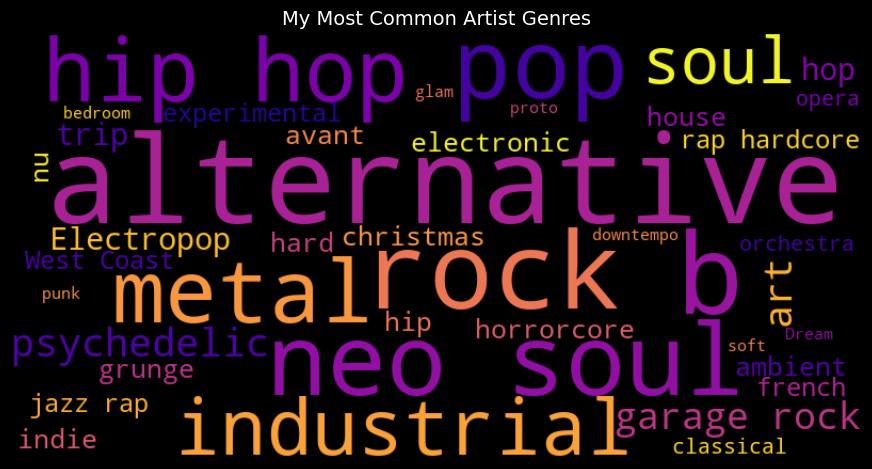

In [105]:
# Combine all genres into a single string
all_genres = ' '.join(all_top_artists['Genres'].dropna())  

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='plasma').generate(all_genres)

# Plot the word cloud
plt.figure(figsize=(11, 18), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("My Most Common Artist Genres", fontsize=14, color='white')
plt.show()

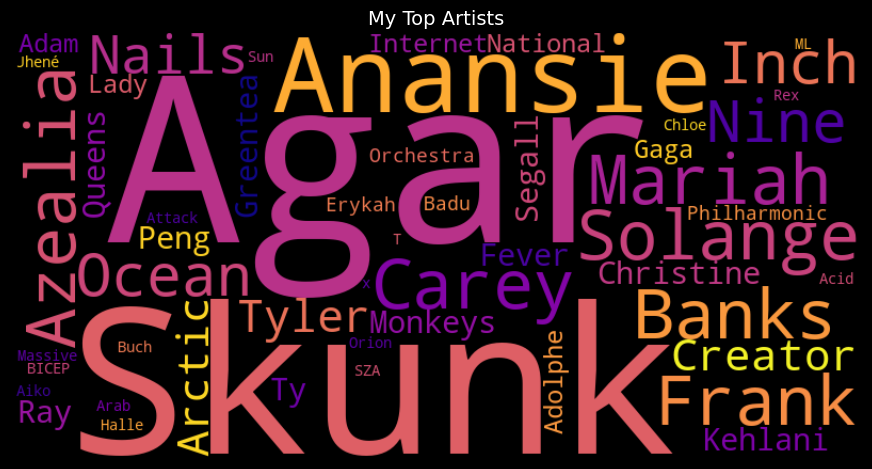

In [106]:
# Combine all genres into a single string
all_artist_names = ' '.join(all_top_artists['name'].dropna())  

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='plasma').generate(all_artist_names)

# Plot the word cloud
plt.figure(figsize=(11, 18), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("My Top Artists", fontsize=14, color='white')
plt.show()

## top tracks from top artists

In [107]:
#my_artists_df['name']

In [109]:
# get better look at top tracks by selecting from top artists the top tracks within

# create function 

def tracks_from_artists(all_top_artists, time_range='medium_term', limit=50):
    results = sp.current_user_top_tracks(time_range=time_range,  limit=limit)
    tracks = []

    '''checking if artists were found'''
    
    # print raw
    
    #print("Raw top tracks fetched:")
    #for item in results['items']:
    #    print(item['name'], "by", [artist['name'] for artist in item['artists']])
    
    #grab top artist names in set
    top_artist_names = set(all_top_artists['name'])
    
    for item in results['items']:
        artist_per_track = [artist['name'] for artist in item['artists']]

        if any(artist in top_artist_names for artist in artist_per_track):
            tracks.append({
                'track name': item['name'],
                'artists': ', '.join(artist_per_track),
                'album': item['album']['name'],
                'release': item['album']['release_date'],
                'track id': item['id'],
                'popularity': item['popularity']
            })
            
    tracks_df = pd.DataFrame(tracks)
    return tracks_df

### _need to get all time frames from api_ 

- will change all tables onwards using top_tracks_from_top_artists
- not ran yet!!! keep as md

t_from_a_short = tracks_from_artists('short_term')
t_from_a_med = tracks_from_artists('med_term')
t_from_a_long = tracks_from_artists('long_term')

# concat all time frames into one df

# new

my_top_tracks_from_top_artists_df = pd.concat([t_from_a_short, t_from_a__med, t_from_a__long]).reset_index(drop=True)
my_top_tracks_from_top_artists_df['release'] = my_top_tracks_from_top_artists_df['release'].apply(date_clean)
my_top_tracks_from_top_artists_df.head()

In [110]:


my_top_tracks_from_top_artists_df = tracks_from_artists(all_top_artists)
my_top_tracks_from_top_artists_df['release'] = my_top_tracks_from_top_artists_df['release'].apply(date_clean)
my_top_tracks_from_top_artists_df.head()


,track name,artists,album,release,track id,popularity
0,Die With A Smile,"Lady Gaga, Bruno Mars",Die With A Smile,2024,2plbrEY59IikOBgBGLjaoe,97
1,Brazen (Weep),Skunk Anansie,Stoosh,1996,1mSVdpc7uHEXYfKVtHd1su,40
2,Charlie Big Potato,Skunk Anansie,Post Orgasmic Chill,1999,7FY6MkxmeSt6WSeC0XnY5m,42
3,Nights,Frank Ocean,Blonde,2016,7eqoqGkKwgOaWNNHx90uEZ,76
4,Pink + White,Frank Ocean,Blonde,2016,3xKsf9qdS1CyvXSMEid6g8,83


# top tracks

In [ ]:
# get top tracks
# following same method as top artists

def get_tracks(time_range='short_term', limit=50):
    results = sp.current_user_top_tracks(time_range=time_range, limit=limit)
    t_tracks = []

    for item in results['items']:
        track_artists = [artist['name'] for artist in item['artists']]
        t_tracks.append({
            'track name': item['name'],
            'artists': ', '.join(track_artists),
            'album': item['album']['name'],
            'release': item['album']['release_date'],
            'duration ms': item['duration_ms'],
            'track id': item['id'],
            'popularity': item['popularity']
        })
    top_tracks_df = pd.DataFrame(t_tracks)
    top_tracks_df['release'].apply(date_clean)
    
    return top_tracks_df

In [112]:
my_tracks_df = get_tracks('short_term')

my_tracks_med_df = get_tracks('medium_term')

my_tracks_long_df = get_tracks('long_term')


### _merge all time frames - long_term (calculated from ~1 year of data and including all new data as it becomes available), medium_term (approximately last 6 months), short_term (approximately last 4 weeks). Default: medium_term_

In [113]:
all_top_tracks = pd.concat([my_tracks_df, my_tracks_med_df, my_tracks_long_df]).reset_index(drop=True).drop_duplicates(subset=['track id'])

In [ ]:
# apply date_clean() to normalise release to year

all_top_tracks['release'] = all_top_tracks['release'].apply(date_clean)


In [ ]:
# convert duration to secs
all_top_tracks['duration ms'] = all_top_tracks['duration ms'] // 1000
# add duration in mins and secs
all_top_tracks['duration mm:ss'] = all_top_tracks['duration ms'].apply(lambda x: f'{int(x // 60):02}:{int(x % 60):02}')

In [116]:
all_top_tracks.rename(columns={'duration ms': 'duration secs'}, inplace=True)

In [117]:
all_top_tracks.head()

,track name,artists,album,release,duration secs,track id,popularity,duration mm:ss
0,Shake It Off,Mariah Carey,The Emancipation of Mimi,2005,232,6rJQTvhKl5GSEA8SWW7t1X,54,03:52
1,Brazen (Weep),Skunk Anansie,Stoosh,1996,271,1mSVdpc7uHEXYfKVtHd1su,40,04:31
2,Silencer,Dub War,Wrong Side Of Beautiful,1996,312,1premcRnMNh9KvM7WWtgz5,12,05:12
3,Get Away,The Internet,Ego Death,2015,148,10SUWedx0zohs8M3OJpnA7,47,02:28
4,Die With A Smile,"Lady Gaga, Bruno Mars",Die With A Smile,2024,251,2plbrEY59IikOBgBGLjaoe,97,04:11


### _scatter plot for track duraation_

- _continuing to play around with styling in plt/seaborn etc - cohesive colour scheme_

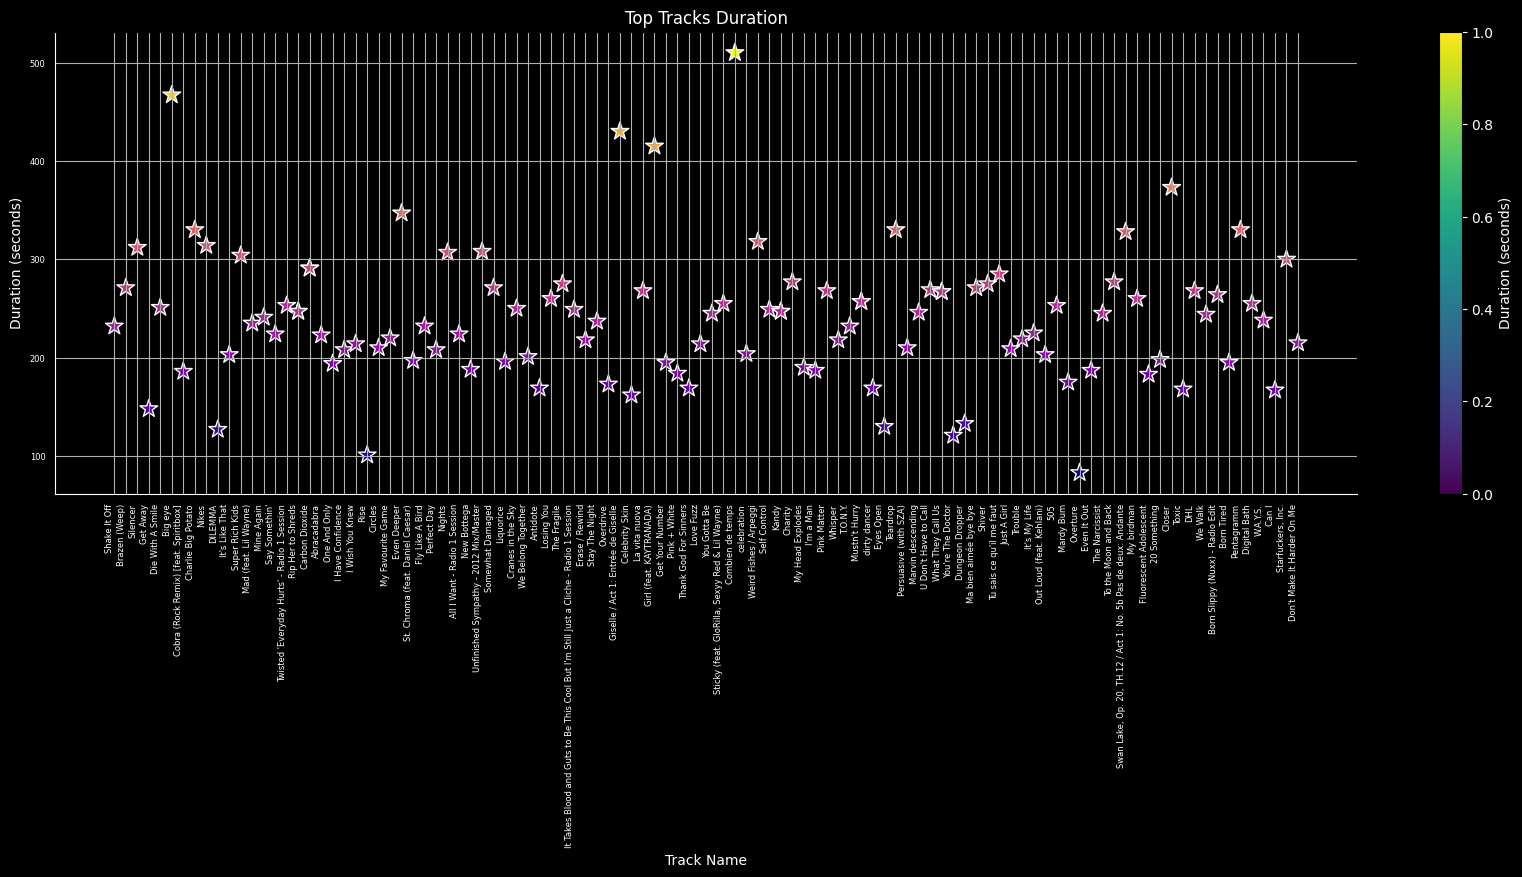

In [ ]:
plt.figure(figsize=(21, 6), facecolor='black')
plt.gca().set_facecolor('black') 

# get min/max from duration values
norm = plt.Normalize(all_top_tracks['duration secs'].min(), all_top_tracks['duration secs'].max())

# import 'plasma' colour scheme
colors = plt.cm.plasma(norm(all_top_tracks['duration secs']))

scatter = plt.scatter(all_top_tracks['track name'], all_top_tracks['duration secs'], color=colors, edgecolors='white', s=180, marker='*') 
plt.xlabel('Track Name', color='white')
plt.ylabel('Duration (seconds)', color='white')
plt.title('Top Tracks Duration', color='white')
plt.xticks(rotation=90, ha='right', fontsize='6', color='white')
plt.yticks(fontsize='6', color='white')

#xy lines
ax = plt.gca()  #grab axis
ax.spines['left'].set_color('white') 
ax.spines['bottom'].set_color('white')

#colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Duration (seconds)', color='white') 
cbar.ax.yaxis.set_tick_params(color='white') 
cbar.ax.yaxis.set_tick_params(labelcolor='white')

plt.grid(True)
plt.show()

### _looking for the percentage of tracks per decade_

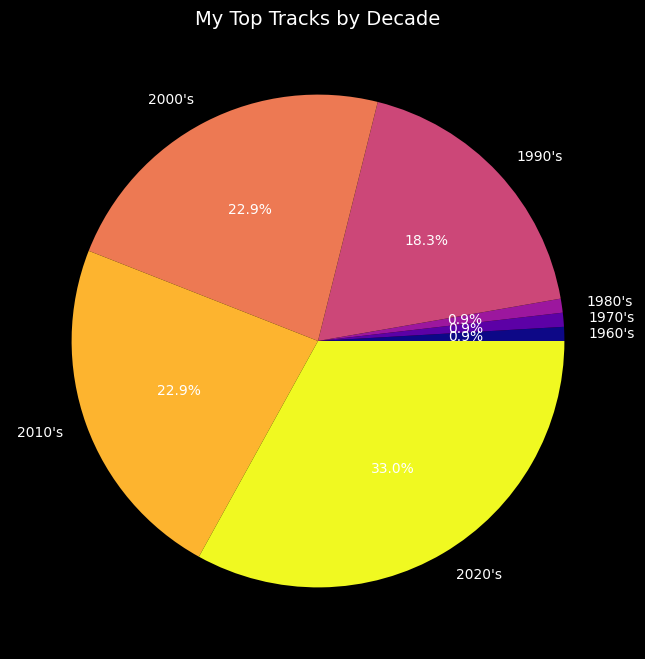

In [132]:
# get decades
all_top_tracks['decade'] = (all_top_tracks['release'] // 10 * 10).astype(str) + "'s"

#count
decade_counts = all_top_tracks['decade'].value_counts().sort_index()

colors = plt.cm.plasma(np.linspace(0, 1, len(decade_counts)))

plt.figure(figsize=(8, 8), facecolor='black')
plt.pie(decade_counts, labels=decade_counts.index, autopct='%1.1f%%', colors=colors, textprops={'color': 'white'})


plt.title('My Top Tracks by Decade', fontsize=14, color='white')

plt.show()

# playlists

### get all

In [ ]:
#get playlists from API sp...

def get_playlists():
    results = sp.current_user_playlists()
    all_playlists = []

    while results:
        for playlist in results['items']:
            all_playlists.append({
                "playlist_name": playlist["name"],
                "total_tracks": playlist["tracks"]["total"],
                "playlist_id": playlist["id"]
            })

        # pagination - load next page
        if results["next"]:
            results = sp.next(results)
        else:
            break
    
    all_playlists = pd.DataFrame(all_playlists)
    return all_playlists


In [121]:
my_playlists = get_playlists()
my_playlists.head()

,playlist_name,total_tracks,playlist_id
0,Gaga in order,25,1VK03kdKyRNc86QkdqFmj9
1,?,1,2Jla4LLDdGndqCKxP7ZeIo
2,mmmm,21,0a68WVAAQcjjlddZGijvOG
3,❤️‍🔥🎧🫠🎧❤️‍🔥,7,0qv3HLAftJbN8Z8glhiCs7
4,Hmmm,12,13km7JNQUh5DRGV9QexgpI


In [ ]:
# continuing API function structure

def get_playlist_tracks(my_playlists, limit=50):
    playlist_tracks = []

    for playlist_id, playlist_name in zip(my_playlists['playlist_id'], my_playlists['playlist_name']): #zip loops through the iterations???
        results = sp.playlist_tracks(playlist_id, limit=limit)  # Get tracks from the playlist

        for item in results['items']:
            track = item.get('track') 
            
            if track:  # 
                playlist_tracks.append({
                    'track_name': track['name'],
                    'artists': ', '.join([artist['name'] for artist in track['artists']]),
                    'album': track['album']['name'],
                    'release_year': track['album']['release_date'],
                    'playlist name': playlist_name,
                    'track_id': track['id'],
                    'playlist_id': playlist_id,
                    'popularity': track['popularity']
                })
    

    tracks_df = pd.DataFrame(playlist_tracks)

    return tracks_df

In [ ]:

my_tracks_from_playlists = get_playlist_tracks(my_playlists)

#my_tracks_from_playlists.drop_duplicates(subset=['track_id'], keep='first', inplace=True) # modified for finding most listened playlists - duplicated dropped for create_playlist.py

# apply date_clean() to normalise release to year
my_tracks_from_playlists['release_year'] = my_tracks_from_playlists['release_year'].apply(date_clean)

#rename columns
my_tracks_from_playlists.rename(columns={'track_name': 'track name', 'release_year': 'release year', 'track_id': 'track id', 'playlist_id': 'playlist id'}, inplace=True)

In [124]:
my_tracks_from_playlists

,track name,artists,album,release year,playlist name,track id,playlist id,popularity
0,Speechless,Lady Gaga,The Fame Monster (UK Deluxe),2009,Gaga in order,36ebL42b6QAqitgzbkIjw5,1VK03kdKyRNc86QkdqFmj9,34
1,The Edge Of Glory,Lady Gaga,Born This Way (International Special Edition V...,2011,Gaga in order,57F80059mWaWFvWG3tBTbO,1VK03kdKyRNc86QkdqFmj9,66
2,Hey Girl,"Lady Gaga, Florence Welch",Joanne (Deluxe),2016,Gaga in order,554PnB96IltLzVlbinBstw,1VK03kdKyRNc86QkdqFmj9,50
3,Alejandro,Lady Gaga,The Fame Monster (UK Deluxe),2009,Gaga in order,0iOu4s8w3pE9vbpb1SHXsL,1VK03kdKyRNc86QkdqFmj9,54
4,Telephone,"Lady Gaga, Beyoncé",The Fame Monster (UK Deluxe),2009,Gaga in order,6nCDnzErqalOaIY3EJM8NK,1VK03kdKyRNc86QkdqFmj9,59
...,...,...,...,...,...,...,...,...
851,Mr. Sun (miss da sun),Greentea Peng,RISING,2019,Greentea Peng Complete Playlist,5E7uh0dIynOaedLv7Aoush,4Ez43npblDHbzx0lCz0jwU,17
852,Sane,Greentea Peng,RISING,2019,Greentea Peng Complete Playlist,3RkdLBGzG6PIgf10eZyqzj,4Ez43npblDHbzx0lCz0jwU,30
853,Liberation,Greentea Peng,RISING,2019,Greentea Peng Complete Playlist,7x0vFyfEmCHNGFAgnELBnf,4Ez43npblDHbzx0lCz0jwU,28
854,Downers,Greentea Peng,Downers,2019,Greentea Peng Complete Playlist,1fnU60yGjhsP1QY335rH2m,4Ez43npblDHbzx0lCz0jwU,48


## convert to csv for creating new plalist

### _see **playlist.py** for more_

In [125]:
my_tracks_from_playlists.to_csv('my_playlist_tracks.csv')

# * _which albums occur across top tracks and playlists?_

* albums [] - if album in all_top_tracks and album in my_tracks_from_playlists: albums.append(aalbum, artist) - print albums ???


In [126]:
#iitterrows

# use set to remove duplicates - for now i only want to see a list - so, list(set(albums))??

In [ ]:
albums = []

#loop through all tracks
for index1, row1 in all_top_tracks.iterrows():
    album1 = row1['album']
    artist1 = row1['artists']

    # get only main artist without features etc
    artist1 = artist1.split(',')[0] 
        
    if album1 in my_tracks_from_playlists['album'].values:
        albums.append((album1, artist1))

albums = list(set(albums))

pprint.pprint(albums)

[('1991 - EP', 'Azealia Banks'),
 ('Tragic Kingdom', 'No Doubt'),
 ('channel ORANGE', 'Frank Ocean'),
 ('The Singles Collection', 'No Doubt'),
 ('Cobra (Rock Remix) [feat. Spiritbox]', 'Megan Thee Stallion'),
 ('A Seat at the Table', 'Solange'),
 ('A Collection of Fleeting Moments and Daydreams', 'Orion Sun'),
 ('Radical Romantics', 'Fever Ray'),
 ('The Fragile', 'Nine Inch Nails'),
 ('In Rainbows', 'Radiohead'),
 ("Whatever People Say I Am, That's What I'm Not", 'Arctic Monkeys'),
 ('Ungodly Hour', 'Chloe x Halle'),
 ('Redcar les adorables étoiles (prologue)', 'Christine and the Queens'),
 ('Ctrl', 'SZA'),
 ('Tchaikovsky: Swan Lake', 'Pyotr Ilyich Tchaikovsky'),
 ('Celebrity Skin', 'Hole'),
 ('White Pony', 'Deftones'),
 ('Broken Hearts Club', 'Syd'),
 ('PARANOÏA, ANGELS, TRUE LOVE', 'Christine and the Queens'),
 ('Perfect Day Single', 'Hoku'),
 ('Souled Out (Deluxe)', 'Jhené Aiko'),
 ('Plunge', 'Fever Ray'),
 ('La vita nuova', 'Christine and the Queens'),
 ('Favourite Worst Nightmare'

### _add playlist id to mytracksfromplaylists to determine which playlist tracks are pulled from_ 
    * need to bring back duplicates
        * _done_ in [123]
    

In [ ]:
# tracks from all_top_tracks fount in playlists

matches = all_top_tracks[all_top_tracks['track id'].isin(my_tracks_from_playlists['track id'])]['track name'].tolist()
pprint.pprint(matches)

['Silencer',
 'Big eye',
 'Cobra (Rock Remix) [feat. Spiritbox]',
 'Super Rich Kids',
 'Mad (feat. Lil Wayne)',
 'Perfect Day',
 'Cranes in the Sky',
 'Antidote',
 'The Fragile',
 'Celebrity Skin',
 'La vita nuova',
 'Pink + White',
 'You Gotta Be',
 'Combien de temps',
 'Weird Fishes / Arpeggi',
 'Self Control',
 'My Head Explodes',
 "U Don't Have to Call",
 'Shiver',
 'Just A Girl',
 'Trouble',
 "It's My Life",
 "Mustn't Hurry",
 'Out Loud (feat. Kehlani)',
 '505',
 'Mardy Bum',
 'Rip Her to Shreds',
 'The Narcissist',
 'To the Moon and Back',
 'Swan Lake, Op. 20, TH.12 / Act 1: No. 5b Pas de deux: Andante',
 'Fluorescent Adolescent',
 '20 Something',
 'Toxic',
 'We Walk',
 'Born Slippy (Nuxx) - Radio Edit',
 'Born Tired',
 'Digital Bath',
 'W.A.Y.S.',
 'Can I',
 'Starfuckers, Inc.',
 "Don't Make It Harder On Me"]


In [ ]:
# create df from matches

track_playlist_matches = all_top_tracks[all_top_tracks['track id'].isin(my_tracks_from_playlists['track id'])].merge(my_tracks_from_playlists[['track id','playlist name', 'playlist id']], on='track id', how='left')

track_playlist_matches.drop(columns=['popularity', 'album', 'release'], axis=1)


,track name,artists,duration secs,track id,duration mm:ss,decade,playlist name,playlist id
0,Silencer,Dub War,312,1premcRnMNh9KvM7WWtgz5,05:12,1990's,the dailies,3kjzy5R1zPdnid2TYUQd2j
1,Big eye,Christine and the Queens,467,0fGbCVPP41cReDwIAuOORJ,07:47,2020's,Hmmm,13km7JNQUh5DRGV9QexgpI
2,Big eye,Christine and the Queens,467,0fGbCVPP41cReDwIAuOORJ,07:47,2020's,the dailies,3kjzy5R1zPdnid2TYUQd2j
3,Cobra (Rock Remix) [feat. Spiritbox],"Megan Thee Stallion, Spiritbox",186,6HNWDjbome8TQp0rYRZTQS,03:06,2020's,the dailies,3kjzy5R1zPdnid2TYUQd2j
4,Super Rich Kids,"Frank Ocean, Earl Sweatshirt",304,0725YWm6Z0TpZ6wrNk64Eb,05:04,2010's,the dailies,3kjzy5R1zPdnid2TYUQd2j
...,...,...,...,...,...,...,...,...
58,Digital Bath,Deftones,255,2jSJm3Gv6GLxduWLenmjKS,04:15,2000's,Chill,4NHOoP5BGZbYrWohyaJJDW
59,W.A.Y.S.,Jhené Aiko,238,7jjKsW39O1i8hKF31ShpV9,03:58,2010's,Chill,4NHOoP5BGZbYrWohyaJJDW
60,Can I,Kehlani,167,0uDdI4fAXCuNhQbmxENdsO,02:47,2020's,Chill,4NHOoP5BGZbYrWohyaJJDW
61,"Starfuckers, Inc.",Nine Inch Nails,300,5RxKqRKJva5ZcVa0ltdxuX,05:00,1990's,the dailies,3kjzy5R1zPdnid2TYUQd2j


### _count amount of top tracks per playlist_

In [ ]:
# determine top playlists from track matches

top_playlists = track_playlist_matches['playlist name'].value_counts()

# eliminate others not > 2
# minimise data - depinding on how many playlists a user has theres could be many with 1 match
# knowing myself i only listen to 4 playlists intentionally, else albums/track radios

top_playlists = top_playlists[top_playlists > 2]

top_playlists

playlist name
the dailies       22
Chill             15
Movie              8
Hmmm               6
My playlist #7     4
Name: count, dtype: int64

* _great. this was the expected output. i mostly listen to those top 2 playlists else, song radios._
* _next, plot_

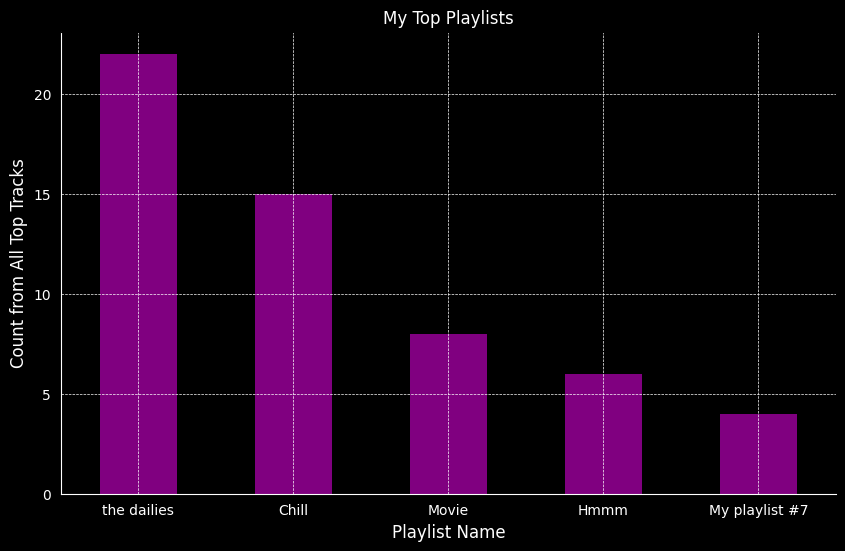

In [ ]:
# plt my most listened to playlists from all_top_tracks count

plt.figure(figsize=(10, 6), facecolor='black')
top_playlists.plot(kind='bar', color='purple')

ax = plt.gca()  

ax.set_facecolor("black")
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

plt.title('My Top Playlists', color='white')
plt.xlabel('Playlist Name', fontsize=12, color='white')
plt.ylabel('Count from All Top Tracks', fontsize=12, color='white')

plt.xticks(rotation=0, ha='center', fontsize=10, color='white')
plt.yticks(fontsize=10, color='white')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.show()